In [2]:
from src.ALMApy import get_k2_vs_radius
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit, root_scalar


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})

In [3]:
G = 6.67e-11

# Dimensions
R_jupiter = 69.9e6

m_neptune = 1.024e26
R_neptune = 24.6e6
rho_neptune = m_neptune/(4*np.pi/3*R_neptune**3)

R_earth = 6378e3
M_earth = 5.972e24
rho_earth = M_earth/(4*np.pi/3*R_earth**3)

# Material properties
rho_air = 1.293
rigidity_air = 1e-7
viscosity_air = 3e-5
rigidity_earth = 1e11
viscosity_earth = 1e21

In [4]:
def get_k2_core(R_core, mu_core, rho_core):
    g_core = 4*np.pi/3*G*rho_core*R_core
    return 3/(2*(1+19*mu_core/(2*g_core*rho_core*R_core)))

### Varying atmosphere density

In [5]:
R_core = R_earth
rho_core = rho_earth
mu_core = rigidity_earth
eta_core = viscosity_earth

no_atm_radii = 100
max_atm_radius = R_jupiter*3

no_rho_atm = 10
min_rho_atm = rho_air
max_rho_atm = 100*rho_air
rho_atms = np.linspace(min_rho_atm, max_rho_atm, no_rho_atm)

data = []

rerun_sim = False
data_file = "varying_atmosphere_density"
if rerun_sim:
    for i,rho_atm in enumerate(rho_atms):
        atmosphere_radii = np.logspace(-3, np.log10((max_atm_radius-R_core)/R_jupiter), no_atm_radii)*R_jupiter + R_core
        k2 = get_k2_vs_radius(R_core, atmosphere_radii, [rho_atm, rho_core], [rigidity_air, mu_core], [viscosity_air, eta_core])
        data.append({"rho_atm": rho_atm,
                     "radius": atmosphere_radii,
                     "k2": k2,})
        print(f"{(i+1)/len(rho_atms)*100:.0f}% done")
    np.savez("data/"+data_file, rho_core=R_core, R_core=R_core, rho_atm=rho_air, data=data)
else:
    data = np.load("data/"+data_file+".npz", allow_pickle=True)
    data = data["data"]

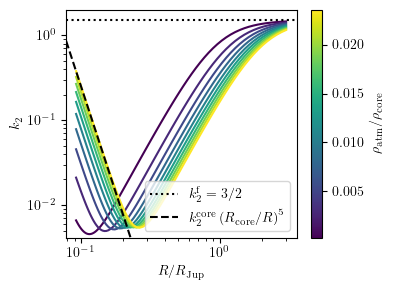

In [18]:
norm = mcolors.Normalize(vmin=min_rho_atm/rho_core, vmax=max_rho_atm/rho_core)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
for i in range(len(rho_atms)):
    ax.plot(data[i]["radius"]/R_jupiter, data[i]["k2"], color=cmap(norm(rho_atms[i]/rho_core)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\rho_\mathrm{atm}/\rho_\mathrm{core}$")

ax.axhline(3/2, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
R_interp = np.logspace(-2, 1, 100)
ax.plot(R_interp, get_k2_core(R_core, mu_core, rho_core)*(R_core/R_interp/R_jupiter)**5, color="black", linestyle="--", label=r"$k_2^\mathrm{core}\left(R_\mathrm{core}/R\right)^5$")

ax.set_xlim(0.07750542656225562, 3.5705100643129137)
ax.set_ylim(0.004071710642668978, 1.987452255373318)
ax.set_xlabel(r"$R/R_\mathrm{Jup}$")
ax.set_ylabel("$k_2$")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()
ax.legend(loc="lower right")
fig.savefig("figures/report/vayring_rho_atm_k2.pdf")
plt.show()



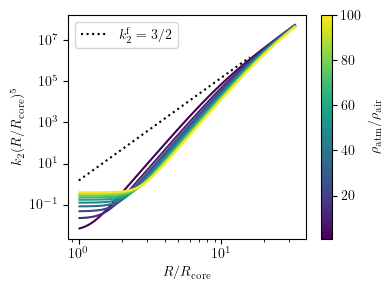

In [17]:
norm = mcolors.Normalize(vmin=min_rho_atm/rho_air, vmax=max_rho_atm/rho_air)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
for i in range(len(rho_atms)):
    ax.plot(data[i]["radius"]/R_core, data[i]["k2"]*(data[i]["radius"]/R_core)**5, color=cmap(norm(rho_atms[i]/rho_air)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\rho_\mathrm{atm}/\rho_\mathrm{air}$")

R_interp = np.logspace(0, 1.2, 100)
ax.plot(R_interp, 3/2*(R_core/R_interp/R_core)**-5, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
#ax.axhline(get_k2_core(R_core, mu_core, rho_core), color="black", linestyle="--", label=r"$k_2^\mathrm{core}$")

#ax.set_xlim(0.8494244773756144, 39.13117803315659)
#ax.set_ylim(0.15607826025802365, 146994897.55297792)

ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel(r"$k_2(R/R_\mathrm{core})^5$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
fig.tight_layout()
fig.savefig("figures/report/varying_rho_atm.pdf")
plt.show()


### Varying $\rho_\mathrm{core}$

In [8]:
R_core = R_earth
rho_atm = rho_air
mu_core = rigidity_earth
eta_core = viscosity_earth

no_atm_radii = 100
max_atm_radius = R_jupiter*3

no_rho_core = 10
min_rho_core = rho_earth/10
max_rho_core = rho_earth
rho_cores = np.linspace(min_rho_core, max_rho_core, no_rho_core)

data = []

rerun_sim = False
data_file = "varying_core_density"
if rerun_sim:
    for i,rho_core in enumerate(rho_cores):
        atmosphere_radii = np.logspace(-3, np.log10((max_atm_radius-R_core)/R_jupiter), no_atm_radii)*R_jupiter + R_core
        k2 = get_k2_vs_radius(R_core, atmosphere_radii, [rho_atm, rho_core], [rigidity_air, mu_core], [viscosity_air, eta_core])
        data.append({"rho_core": rho_core,
                     "radius": atmosphere_radii,
                     "k2": k2,})
        print(f"{(i+1)/len(rho_cores)*100:.0f}% done")
    np.savez("data/"+data_file, rho_core=R_core, R_core=R_core, rho_atm=rho_air, data=data)
else:
    data = np.load("data/"+data_file+".npz", allow_pickle=True)
    data = data["data"]

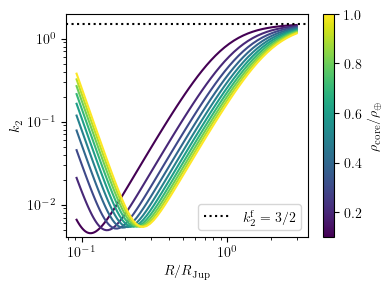

In [ ]:
norm = mcolors.Normalize(vmin=min_rho_core/rho_earth, vmax=max_rho_core/rho_earth)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
for i in range(len(rho_cores)):
    ax.plot(data[i]["radius"]/R_jupiter, data[i]["k2"], color=cmap(norm(rho_cores[i]/rho_earth)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\rho_\mathrm{core}/\rho_\oplus$")

ax.axhline(3/2, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
#R_interp = np.logspace(-2, 1, 100)
#ax.plot(R_interp, get_k2_core(R_core, mu_core, rho_core)*(R_core/R_interp/R_jupiter)**5, color="black", linestyle="--", label=r"$k_2^\mathrm{core}\left(R_\mathrm{core}/R\right)^5$")

ax.set_xlim(0.07750542656225562, 3.5705100643129137)
ax.set_ylim(0.004071710642668978, 1.987452255373318)
ax.set_xlabel(r"$R/R_\mathrm{Jup}$")
ax.set_ylabel("$k_2$")
ax.set_xscale("log")
ax.set_yscale("log")
fig.tight_layout()
ax.legend(loc="lower right")
fig.savefig("figures/report/vayring_rho_core_k2.pdf")
plt.show()



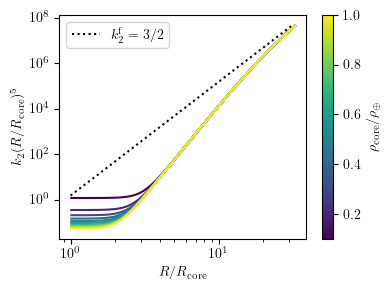

In [32]:
norm = mcolors.Normalize(vmin=min_rho_core/rho_earth, vmax=max_rho_core/rho_earth)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
for i in range(len(rho_atms)):
    ax.plot(data[i]["radius"]/R_core, data[i]["k2"]*(data[i]["radius"]/R_core)**5, color=cmap(norm(rho_cores[i]/rho_earth)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\rho_\mathrm{core}/\rho_\oplus$")

R_interp = np.logspace(0, 1.5, 100)
ax.plot(R_interp, 3/2*(R_core/R_interp/R_core)**-5, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
#ax.axhline(get_k2_core(R_core, mu_core, rho_core), color="black", linestyle="--", label=r"$k_2^\mathrm{core}$")


ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel(r"$k_2(R/R_\mathrm{core})^5$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
fig.tight_layout()
fig.savefig("figures/report/varying_rho_core.pdf")
plt.show()


### Varying $\mu_\mathrm{core}$

In [34]:
R_core = R_earth
rho_atm = rho_air
rho_core = rho_earth
#mu_core = rigidity_earth
eta_core = viscosity_earth

no_atm_radii = 100
max_atm_radius = R_jupiter*3

no_mu_core = 10
min_mu_core = rigidity_earth/10
max_mu_core = rigidity_earth*10
mu_cores = np.linspace(min_mu_core, max_mu_core, no_mu_core)

data = []

rerun_sim = False
data_file = "varying_core_rigidity"
if rerun_sim:
    for i,mu_core in enumerate(mu_cores):
        atmosphere_radii = np.logspace(-3, np.log10((max_atm_radius-R_core)/R_jupiter), no_atm_radii)*R_jupiter + R_core
        k2 = get_k2_vs_radius(R_core, atmosphere_radii, [rho_atm, rho_core], [rigidity_air, mu_core], [viscosity_air, eta_core])
        data.append({"rho_core": rho_core,
                     "radius": atmosphere_radii,
                     "k2": k2,})
        print(f"{(i+1)/len(mu_cores)*100:.0f}% done")
    np.savez("data/"+data_file, rho_core=R_core, R_core=R_core, rho_atm=rho_air, data=data)
else:
    data = np.load("data/"+data_file+".npz", allow_pickle=True)
    data = data["data"]

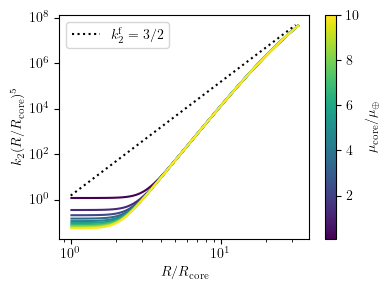

In [35]:
norm = mcolors.Normalize(vmin=min_mu_core/rigidity_earth, vmax=max_mu_core/rigidity_earth)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
for i in range(len(mu_cores)):
    ax.plot(data[i]["radius"]/R_core, data[i]["k2"]*(data[i]["radius"]/R_core)**5, color=cmap(norm(mu_cores[i]/rigidity_earth)))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\mu_\mathrm{core}/\mu_\oplus$")

R_interp = np.logspace(0, 1.5, 100)
ax.plot(R_interp, 3/2*(R_core/R_interp/R_core)**-5, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
#ax.axhline(get_k2_core(R_core, mu_core, rho_core), color="black", linestyle="--", label=r"$k_2^\mathrm{core}$")


ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel(r"$k_2(R/R_\mathrm{core})^5$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
fig.tight_layout()
fig.savefig("figures/report/varying_mu_core.pdf")
plt.show()


### Old stuff

[ 0.39944827  3.18685191 21.96531249  7.90870719  2.99183469]


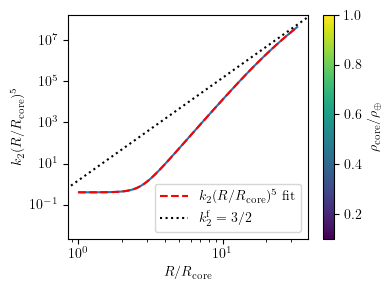

In [11]:
norm = mcolors.Normalize(vmin=min_rho_core/rho_earth, vmax=max_rho_core/rho_earth)
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(4,3))
#for i in range(len(rho_atms)):
i = -1
ax.plot(data[i]["radius"]/R_core, data[i]["k2"]*(data[i]["radius"]/R_core)**5)#, color=cmap(norm(rho_cores[i]/rho_earth)))

R_interp = np.logspace(0,1.5,100)
def k2_func(x, k2_core, x1, x2, b1, b2):
    a2 = 5
    a1 = -a2*np.log(x2)/np.log(x1/x2)
    #print(a1)
    return k2_core - 3/2 + 3/2*(1+(x/x1)**np.sqrt(a1*b1))**np.sqrt(a1/b1)*(1+(x/x2)**np.sqrt((a1-a2)*b2))**(-np.sqrt((a1-a2)/b2))

def log_k2_func(x, k2_core, x1, x2, b1, b2):
    return np.log(k2_func(x, k2_core, x1, x2, b1, b2))
#ax.plot(R_interp, k2_func(R_interp, 0.399, 3.37, 20, 10,2), color="black",)

popt,pcov = curve_fit(log_k2_func, data[i]["radius"]/R_core, np.log(data[i]["k2"]*(data[i]["radius"]/R_core)**5), p0=[0.399, 3.37, 20, 10, 2])

ax.plot(R_interp, k2_func(R_interp, *popt), color="red", linestyle="--", label=r"$k_2(R/R_\mathrm{core})^5$ fit")
print(popt)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\rho_\mathrm{core}/\rho_\oplus$")

R_interp = np.logspace(-1, 2, 100)
ax.plot(R_interp, 3/2*(R_core/R_interp/R_core)**-5, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
#ax.axhline(get_k2_core(R_core, mu_core, rho_core), color="black", linestyle="--", label=r"$k_2^\mathrm{core}$")

ax.set_xlim(0.8494244773756144, 39.13117803315659)
ax.set_ylim(0.0022225180403935164, 175059812.96411967)

ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel(r"$k_2(R/R_\mathrm{core})^5$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("figures/report/varying_rho_core_k2R5.pdf")
plt.show()
